# Movie Ratings Analysis with IMDb-Style Weighted Rating

## Purpose
You have joined a local movie cineplex as a movie scheduler. Your colleague Zoe wants to optimize scheduling and help cineplex grow its revenue. She collected movie sales data over the years and would like your help to determine if there is a change in the types of movies that excite audiences.

## Assumptions
Movie sales come from the local cineplex and not online streaming or external sources. Ratings were given after the person watched the movie in the local cineplex.

## Contents

### 1. **Data Preparation**
- Clean and transform movie genres into a list.
- Extract release year from the `release_date`.
- Create EDA report to understand data

### 2. **User Preferences & Rating Behavior**
- Explored genre preferences by analyzing genre rating counts.
- Used bar and line plots to understand genre distribution and popularity trends over time.

### 3. **IMDb-Style Weighted Rating**
- Calculated a custom weighted rating (WR) using IMDb’s formula:
  - `C`: Global average rating across all movies.
  - `m`: Minimum vote count threshold (95th percentile).
  - Weighted rating combines vote count and average rating for a more balanced score.

### 4. **Top 250 Movies Genre Analysis**
- Ranked movies by WR and selected the Top 250.
- Visualized genre dominance, release year distribution, and trends by decade.


## Key Insights
- **Top Genres:** Drama, Action, and Comedy frequently appear in the Top 250.
- **User Preferences:** Users exhibit distinct genre interests, which can inform scheduling.
- **Genre Evolution:** Genre popularity evolves over decades, with Science Fiction showing the most dynamic growth.


In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from ast import literal_eval
import numpy as np
from dotenv import load_dotenv
import os

### 1. Data Preparation

In [2]:
# Function to explore DataFrame and generate EDA report
def explore_csv(df: pd.DataFrame, name: str = "DataFrame", output_path: str = "./"):
    """
    Function to perform basic EDA on a DataFrame and save the report to a text file.
    Arguments:
    - df: DataFrame to explore
    - name: Name of the DataFrame (used in report)
    - output_path: Directory path to save the report
    Returns:
    - file_path: Path to the generated EDA report file
    """
    print(f"\n--- Exploring {name} ---\n")
    
    # Ensure output path exists
    os.makedirs(output_path, exist_ok=True)

    file_path = os.path.join(output_path, f"{name.lower().replace(' ', '_')}_eda.txt")
    
    with open(file_path, mode='w', encoding='utf-8') as temp_file:
        temp_file.write(f"EDA Report for: {name}\n")
        temp_file.write("=" * 50 + "\n\n")
        
        # Basic Data Info
        temp_file.write("Basic Info:\n")
        temp_file.write(f"Shape: {df.shape}\n")
        temp_file.write(f"Columns: {list(df.columns)}\n")
        temp_file.write(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB\n\n")
        
        # Data Types
        temp_file.write("Data Types:\n")
        temp_file.write(str(df.dtypes) + "\n\n")

        # Column Type Distribution
        temp_file.write("Column Type Distribution:\n")
        temp_file.write(f"Numerical: {df.select_dtypes(include='number').shape[1]}\n")
        temp_file.write(f"Categorical: {df.select_dtypes(include='object').shape[1]}\n")
        temp_file.write(f"Datetime: {df.select_dtypes(include='datetime').shape[1]}\n\n")

        # Identify columns with unhashable types (like lists)
        hashable_cols = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, (str, int, float, bool, type(None), np.number))).all()]
        
        # Duplicate rows (only for hashable columns)
        duplicate_rows = df[hashable_cols][df[hashable_cols].duplicated()]
        temp_file.write(f"Number of duplicate rows (hashable cols only): {duplicate_rows.shape[0]}\n\n")

        # Null values
        nulls = df.isnull().sum()
        nulls_with_values = nulls[lambda x: x > 0]
        if not nulls_with_values.empty:
            temp_file.write("Columns with null values:\n")
            temp_file.write(str(nulls_with_values) + "\n\n")
        else:
            temp_file.write("No columns with null values.\n\n")

        # Unique values per column
        temp_file.write("Unique Values per Column:\n")
        for col in df.columns:
            try:
                nunique = df[col].nunique()
                temp_file.write(f"{col}: {nunique} unique values\n")
            except TypeError:
                temp_file.write(f"{col}: contains unhashable types (e.g., list), skipped.\n")
        temp_file.write("\n")

        # Cardinality warnings
        temp_file.write("Potential High Cardinality Columns (nunique > 1000):\n")
        high_card_cols = []
        for col in df.columns:
            try:
                if df[col].nunique() > 1000:
                    high_card_cols.append(col)
            except TypeError:
                continue  # Skip unhashable columns
        if high_card_cols:
            temp_file.write(", ".join(high_card_cols) + "\n\n")
        else:
            temp_file.write("None\n\n")

        # Summary statistics for numerical columns
        temp_file.write("Summary Statistics for Numerical Columns:\n")
        temp_file.write(str(df.describe().transpose()) + "\n\n")

    return file_path

In [3]:
# Load environment variables and read the Movies dataset
load_dotenv()
movies = pd.read_csv(os.getenv("MOVIES_PATH"), parse_dates=['release_date'], low_memory=False)
movies.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [4]:
# Generate EDA report for Movies dataset
file_location = explore_csv(movies, name="Movies", output_path="./eda_reports")
print(f"EDA report written to: {file_location}")


--- Exploring Movies ---

EDA report written to: ./eda_reports\movies_eda.txt


In [5]:
# Clean and parse genres data, handle missing values
# Replace missing genres with an empty list to prevent errors in downstream operations
# Evaluate genre string and convert to list of genres
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [6]:
# Extract the year from the release date
# Handling errors in conversion will convert invalid dates to NaT
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').dt.year

In [7]:
# Read ratings data
ratings = pd.read_csv(os.getenv("RATINGS_PATH"))
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [8]:
# Generate EDA report for Ratings dataset
file_location = explore_csv(ratings, name="Ratings", output_path="./eda_reports")
print(f"EDA report written to: {file_location}")


--- Exploring Ratings ---

EDA report written to: ./eda_reports\ratings_eda.txt


### 2. User Preference & Rating Behavior

In [9]:
# Merge ratings with movie genres and explode the genres list
movies['id'] = movies['id'].astype(str)
ratings['movieId'] = ratings['movieId'].astype(str)

movie_genres = movies[['id', 'genres']]
merged = ratings.merge(movie_genres, left_on='movieId', right_on='id', how='inner')

# Explode genres into individual rows for analysis
merged_exploded = merged.explode('genres')

         userId            genre  count
0             1           Action      1
1             1           Comedy      4
2             1            Crime      1
3             1      Documentary      1
4             1            Drama      8
...         ...              ...    ...
3348577  270896          Romance     20
3348578  270896  Science Fiction     14
3348579  270896         Thriller     28
3348580  270896              War      2
3348581  270896          Western      4

[3348582 rows x 3 columns]


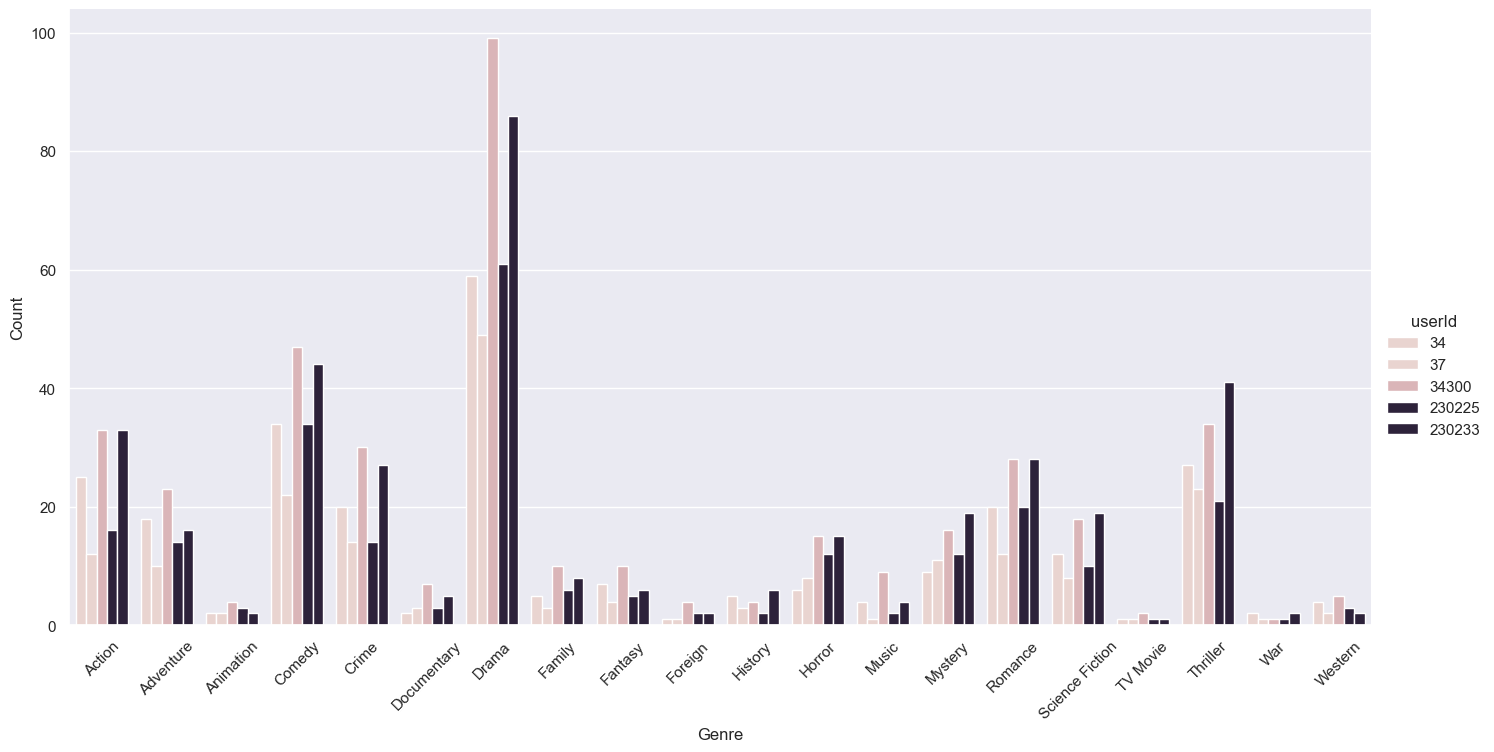

In [24]:
# Group by user and genre, then count ratings
user_genre_counts = merged_exploded.groupby(['userId', 'genres'])['rating'].count().reset_index()
user_genre_counts = user_genre_counts.rename(columns={'genres': 'genre', 'rating': 'count'})
print(user_genre_counts)
# Filter top 5 active users
top_users = user_genre_counts['userId'].value_counts().head(5).index
subset = user_genre_counts[user_genre_counts['userId'].isin(top_users)]

# Plot the top genres for frequent users
sns.set_theme(style="darkgrid") 

g = sns.catplot(
    data=subset,
    kind="bar",
    x="genre",
    y="count",
    hue="userId",
    height=7,
    aspect=2
)

g.set_axis_labels("Genre", "Count")
g.set_titles("User Genre Preference Count Plot")
g.set_xticklabels(rotation=45)

### User Behavior & Clustering Potential

#### Key Insights

- **User 34300:** Power viewer — watched ~100 Drama films, plus high engagement with Comedy, Thriller, and Crime genres. Suggests a strong emotional/narrative preference.
- **User 34 & 37:** Balanced viewers — lean toward lighter or family-oriented genres like Comedy, Romance, Animation, and Drama.

#### Assumptions

- Genre preferences inferred from rating counts per user.

#### Further Analysis: Clustering Users by Genre Preference

- **Objective:** Segment users into groups based on genre consumption using K-Means.
- **Steps:**
  1. Normalize counts to prevent domination by high-volume viewers.
  2. Apply dimensionality reduction (PCA/t-SNE) for visualization.
  3. Cluster users and assign segment labels.
  4. Profile each cluster's genre behavior.

#### Benefits

- Drive personalized recommendations.
- Target marketing campaigns by audience segment.
- Reveal niche genre clusters for specialized screenings.

#### Advanced Angle

- **Temporal Clustering:** Understand how preferences evolve by year.
- Use interactive visualizations (e.g., Plotly animations) to explore shifting behaviors.
- This reinforces the decade-wise genre trends seen in later blocks.

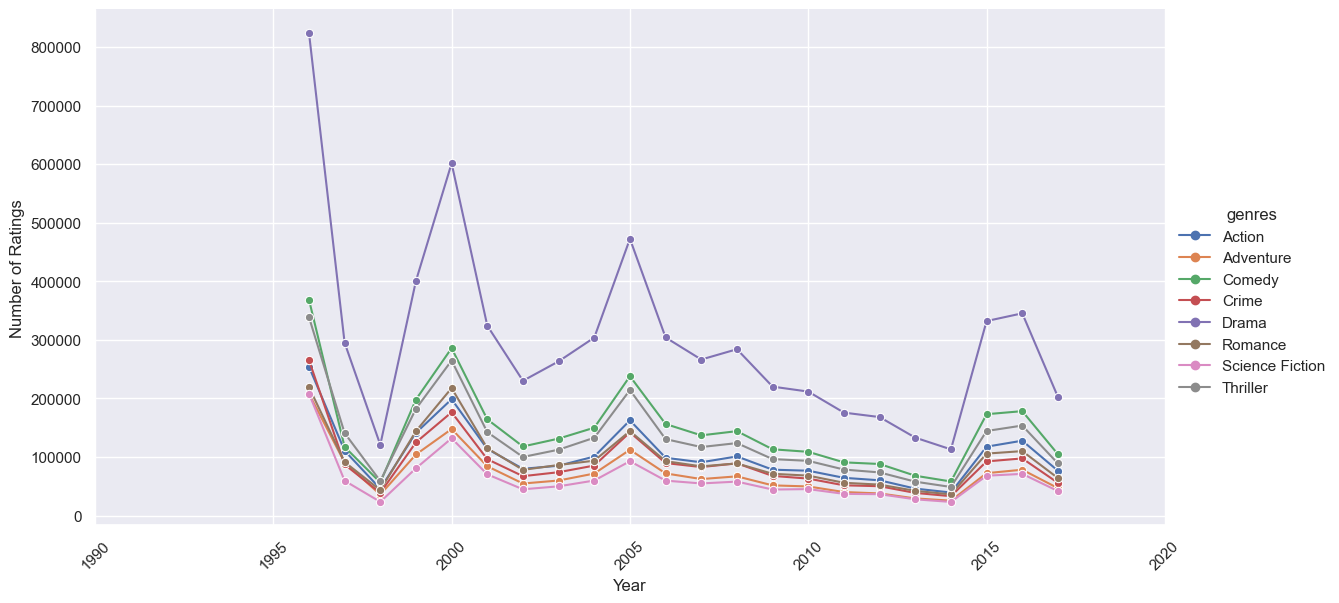

In [11]:
# Convert timestamp to datetime and extract year
merged_exploded['timestamp'] = pd.to_datetime(merged_exploded['timestamp'], unit='s')
merged_exploded['year'] = merged_exploded['timestamp'].dt.year

# Group by year and genre to track genre popularity trends
genre_trend = merged_exploded.groupby(['year', 'genres']).size().reset_index(name='count')

# Filter to top 8 genres for clean visualization
top_genres = genre_trend.groupby('genres')['count'].sum().sort_values(ascending=False).head(8).index
genre_trend_top = genre_trend[genre_trend['genres'].isin(top_genres)]

# Plot the genre trends over time
sns.set_theme(style="darkgrid")  # optional styling

g = sns.relplot(
    data=genre_trend_top,
    kind="line",
    x="year",
    y="count",
    hue="genres",
    marker="o",
    height=6,
    aspect=2
)

g.set_axis_labels("Year", "Number of Ratings")
g.set_titles("Trends in Genre Popularity Over Time")
g.set_xticklabels(rotation=45)

### Key Insights from Genre Ratings Over Time

- Drama consistently leads across years, peaking in the late 1990s and mid-2000s.
- Comedy and Action remain consistently popular, suggesting reliable audience appeal.
- Spikes across genres could indicate blockbuster hits, release strategies, technological advances.
- Post-2005 decline may not reflect interest loss, but rather a shift in platforms (rise of streaming services over cinema).

#### Reinforcement
- These findings support Zoe's goal to adjust scheduling strategies — prioritizing drama-heavy lineups.

#### Further Analysis
- Use time-series forecasting (ARIMA, Prophet) to predict future genre popularity.
- Investigate specific years of spikes for key drivers: franchise launches, technological advanced in theatres, etc.
- Drill down to month to see if there are specific months that contribute to certain genre spikes or dips. 


### 3. IMDb-Style Weighted Rating

In [12]:
# Calculate the mean of vote averages (C) and 95th percentile of vote counts (m)
vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('float')
C = vote_averages.mean()  # Mean vote across all movies (C)
m = vote_counts.quantile(0.95)  # 95th percentile of vote counts (m)

In [13]:
# Define the weighted rating formula based on IMDb's formula
def weighted_rating(x):
    """
    Calculates the weighted rating for a movie based on vote count and average vote.
    Arguments:
    - x: DataFrame row with 'vote_count' and 'vote_average'
    Returns:
    - Weighted rating for the movie
    """
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v + m) * R) + (m / (m + v) * C)

In [14]:
# Apply weighted rating and filter the top movies based on certain conditions
movies['popularity'] = pd.to_numeric(movies['popularity'], errors='coerce')
qualified = movies[
    (movies['vote_count'] >= m) & 
    (movies['vote_count'].notnull()) & 
    (movies['vote_average'].notnull())
][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False).head(250)

### 4. Top 250: Genre Analysis

Counter({'Drama': 144, 'Adventure': 67, 'Thriller': 63, 'Action': 62, 'Science Fiction': 46, 'Comedy': 43, 'Crime': 42, 'Fantasy': 40, 'Family': 39, 'Romance': 31, 'Animation': 30, 'Mystery': 23, 'War': 17, 'History': 12, 'Horror': 9, 'Western': 7, 'Music': 4})


C:\Users\sarmi\AppData\Local\Temp\ipykernel_11888\1940383906.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_df, x='Count', y='Genre', palette='flare')


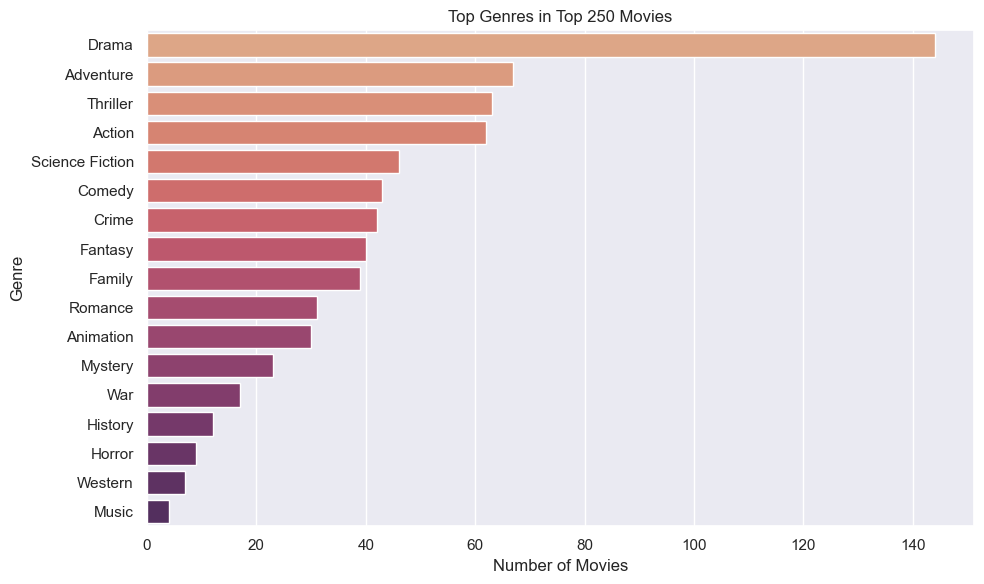

In [15]:
# Visualize the top genres in the top 250 movies
genre_counter = Counter()
for genres in qualified['genres']:
    genre_counter.update(genres)
print(genre_counter)

# Create a DataFrame for genre counts
genre_df = pd.DataFrame(genre_counter.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Plot the top genres
sns.set_theme(style="darkgrid")  
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_df, x='Count', y='Genre', palette='flare')
plt.title('Top Genres in Top 250 Movies')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()

### Top 250 Genre Breakdown

- Drama is overwhelmingly dominant in the Top 250 — both critically acclaimed and widely rated.
- Adventure, Thriller, Action serve as strong secondary genres.
- Comedy, Sci-Fi, and Crime maintain steady mid-tier presence.

#### Reinforcement
- Aligns with earlier findings that Drama is a cornerstone genre. Zoe can prioritize drama films across regular screenings or targeted campaigns.


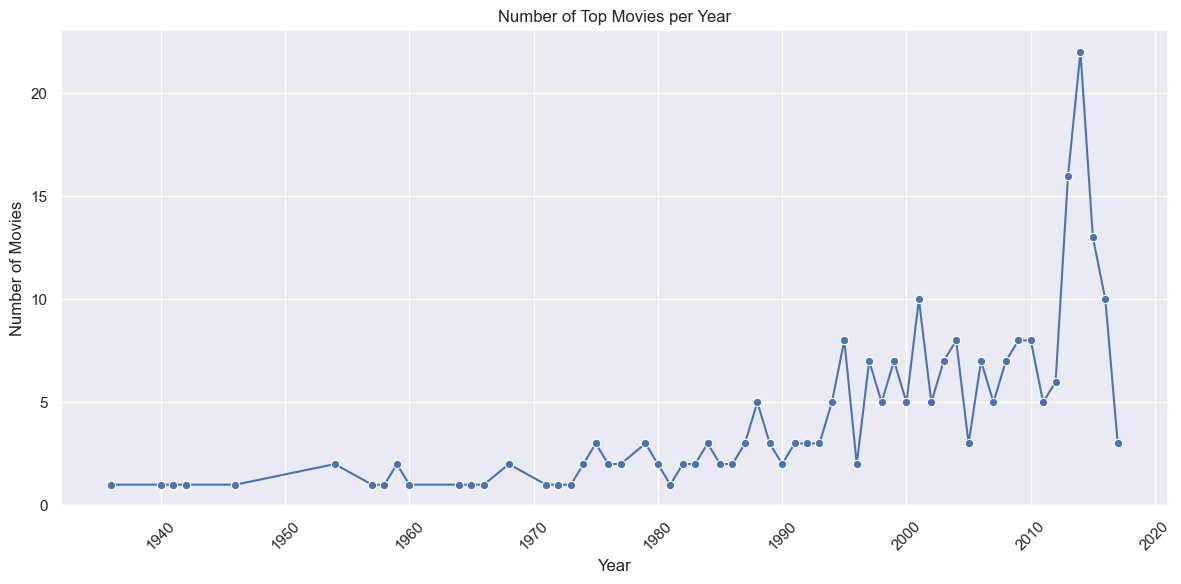

In [16]:
# Plot the number of top movies per year
year_counts = qualified['year'].value_counts().sort_index()
year_counts = year_counts.dropna()

plt.figure(figsize=(12, 6))
year_counts = year_counts.astype(int)
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
plt.xticks(rotation=45)
plt.title('Number of Top Movies per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

C:\Users\sarmi\AppData\Local\Temp\ipykernel_11888\4126519906.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=decade_counts.index, y=decade_counts.values, palette='coolwarm')


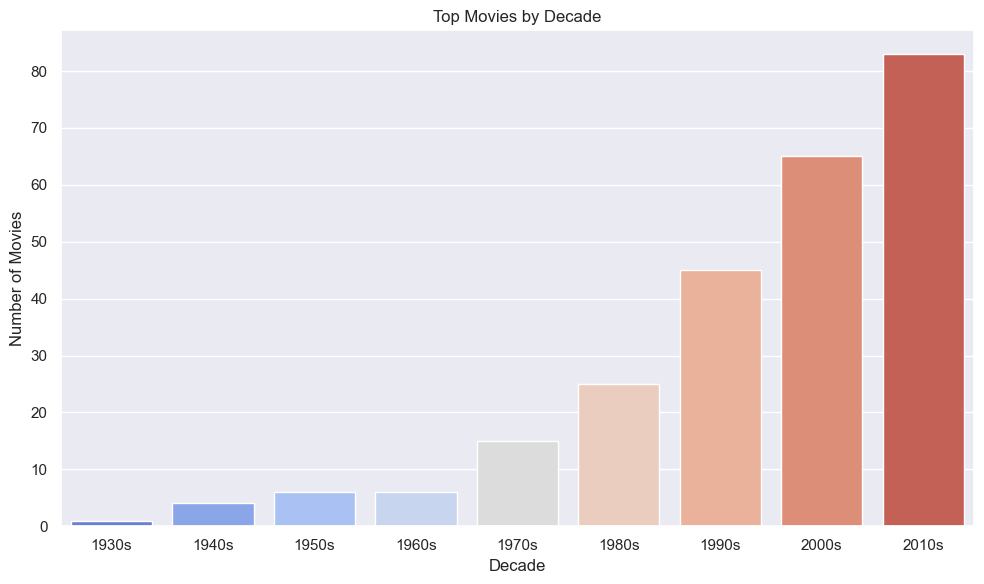

In [17]:
# Top movies by decade
qualified['decade'] = qualified['year'].astype(str).str[:3] + '0s'
decade_counts = qualified['decade'].value_counts().sort_index()

# Plot the top movies by decade
plt.figure(figsize=(10, 6))
sns.barplot(x=decade_counts.index, y=decade_counts.values, palette='coolwarm')
plt.title('Top Movies by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

###  Key Insights

- Most Top 250 movies were released **post-1990**, with a fairly large concentration in the 1990s and 2000s.
- **Marketing Implication:** Hosting nostalgic events (e.g., *“90s Movie Night”*) can tap into generational sentiment and increase attendance.

#### Reinforcement
- This supports scheduling decisions based on cultural memory and aligns with known engagement spikes for older blockbusters or anniversary re-releases.


In [18]:
# Explode genres into separate rows for accurate year-genre grouping
qualified_exploded = qualified.copy()
qualified_exploded['genres'] = qualified_exploded['genres'].apply(lambda x: x if isinstance(x, list) else [])
qualified_exploded = qualified_exploded.explode('genres')

# Group by year and genre, then count occurrences
genre_trend = (
    qualified_exploded.groupby(['decade', 'genres'])
    .size()
    .reset_index(name='count')
)

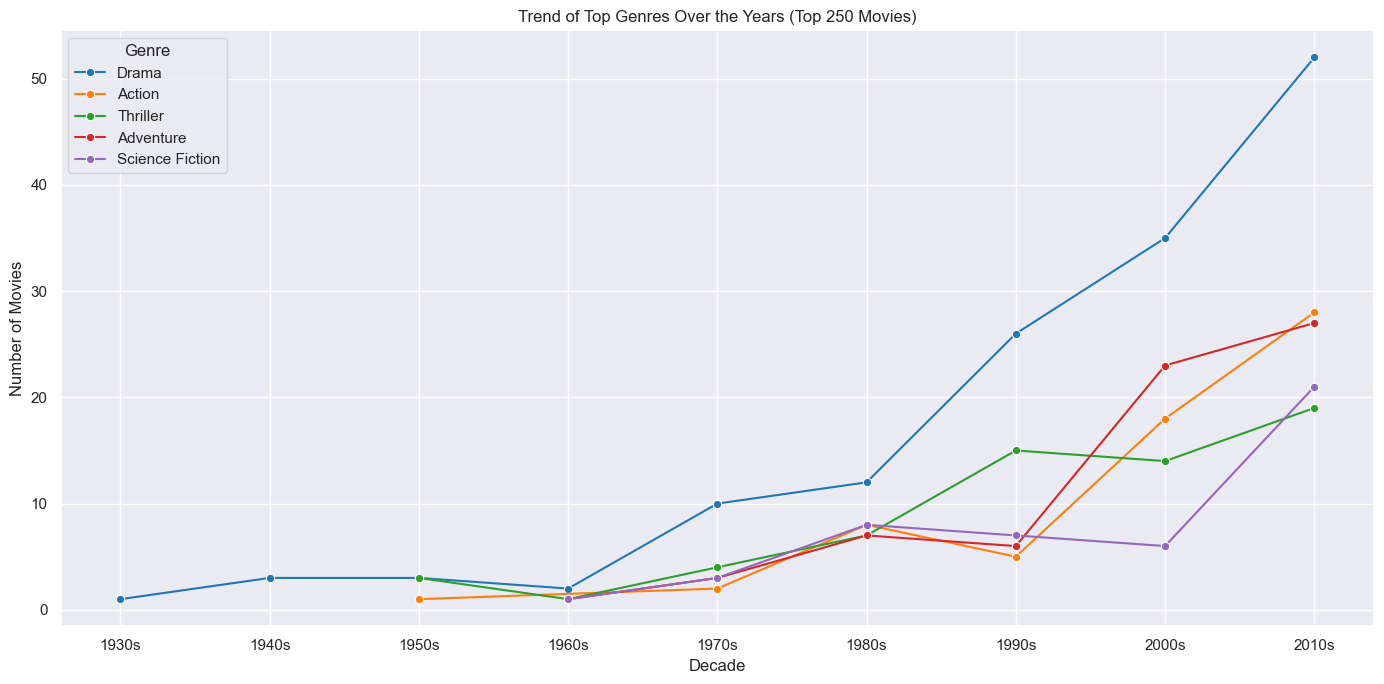

In [19]:
# Filter top N genres for clarity (e.g., top 5 overall)
top_genres = genre_df.head(5)['Genre'].tolist()
genre_trend = genre_trend[genre_trend['genres'].isin(top_genres)]

# Plot the genre trend over the years
plt.figure(figsize=(14, 7))
sns.lineplot(data=genre_trend, x='decade', y='count', hue='genres', marker='o', palette='tab10')
plt.title('Trend of Top Genres Over the Years (Top 250 Movies)')
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.legend(title='Genre')
plt.tight_layout()
plt.show()

### Genre Evolution by Decade

#### Overall Upward Trend for Top Genres
- Across decades, Drama, Action, Comedy, Sci-Fi, and Thriller all show a rise in top-rated entries.
- Suggests these genres are gaining cultural traction and critical appreciation.

#### Science Fiction’s Golden Age
- Sharp surge in Sci-Fi popularity between 2000s and 2010s.
- Influenced by:
  - Technological advancements in VFX.
  - Success of franchises like *Inception*, *Interstellar*, *MCU*.
  - Rising mainstream appetite for speculative narratives.

### Interpretation
- Highlights an era shift: Science Fiction is entering a creative and commercial peak.
- Zoe can leverage this insight by increasing sci-fi screenings and including tech-forward narratives in promotions.

#### Reinforcement
- Connects back to clustering possibilities and temporal shifts in user preferences. Shows the synergy between genre analytics and behavioral segmentation.


### Final Summary & Business Implications

- **Drama is foundational**, appearing as a top genre across users, ratings, and decades.
- **Sci-Fi is rising rapidly**, signaling a genre worth scheduling more frequently — especially among younger or tech-savvy audiences.
- **User segmentation** reveals varied genre appetites. High-engagement users lean emotional/intense, while others favor lighter or family genres.
- **Nostalgia sells** — especially targeting films from the 90s and 2000s.
- **Future opportunity:** Use clustering and time-series modeling to build genre-driven programming blocks aligned with evolving viewer preferences.

Zoe  can combine these insights to drive smarter scheduling, targeted promotions, and audience engagement strategies that boost both ticket sales and viewer satisfaction.
